In [72]:
import IPython.display as ipd
from python_speech_features import mfcc
import scipy.io.wavfile as wav
from scipy.fftpack import dct
from zipfile import ZipFile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [73]:
nclass = 7
naudio = 29
rate, data = wav.read('Read_Up/IDR' + str(nclass) + '/' + str(naudio) + '.wav')
# 'Read_Up/IDR' + str(nclass) + '/' + str(naudio) + '.wav'

In [74]:
#data input. single 
rate, data = wav.read('Read_Up/IDR9/4.wav')
ipd.Audio('Read_Up/IDR3/3.wav')

In [75]:
#frame pre-calculation 
framelength, framestride, nfft, num_fbanks, n_cep_coeff = 0.025, 0.015, 512, 40, 12
frmlen, frmstrd, signallen = int(round(rate*framelength)), int(round(rate*framestride)), len(data)
paddinglen = frmstrd - ((signallen - frmlen)%frmstrd)
paddedsig = np.concatenate((data, np.zeros(paddinglen)), axis = 0)
paddedsiglen = len(paddedsig)
nframes = int(np.floor((paddedsiglen - frmlen)/frmstrd) + 1)
indices = np.tile(np.arange(0, frmlen), (nframes, 1)) + np.tile((np.arange(0, nframes*frmstrd, frmstrd)), (frmlen, 1)).T
frames = paddedsig[indices]

Text(0.5,1,'Frame BEFORE application of Hamming Window')

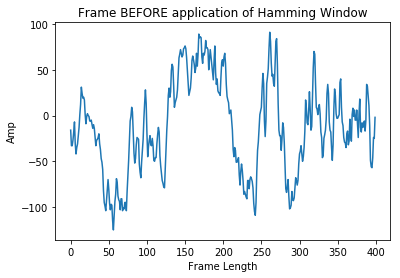

In [76]:
plt.plot(frames[0,:])
plt.xlabel('Frame Length')
plt.ylabel('Amp')
plt.title('Frame BEFORE application of Hamming Window')

Text(0.5,1,'Frame AFTER application of Hamming Window')

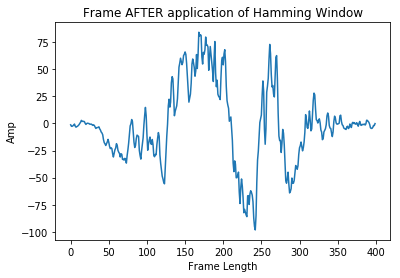

In [77]:
#windowing with hamming window
frames[0,:] *= np.hamming(frmlen)
plt.plot(frames[0, :])
plt.xlabel('Frame Length')
plt.ylabel('Amp')
plt.title('Frame AFTER application of Hamming Window')

In [8]:
#power spectrum periodogram. taking periodogram for each frame. real fft takes removes conjugate symmetric values. 
frame_fft = np.absolute(np.fft.rfft(frames, n = nfft, axis = 1))
frame_periodogram = np.square(frame_fft)/nfft

In [9]:
def freq_to_mel(freq):
    return 2595*np.log10(1+freq/700)
def mel_to_freq(mel):
    return 700*(np.power(10, mel/2595) - 1)

Text(0.5,1,'40 MEL FILTER AB')

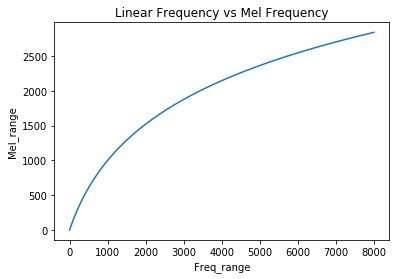

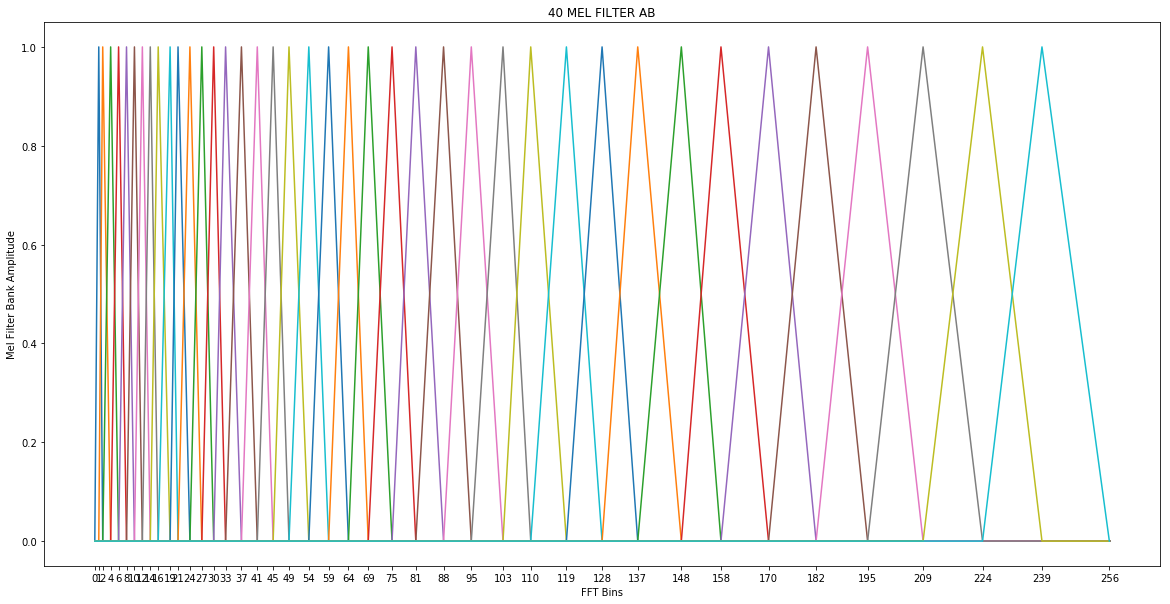

In [52]:
# making mel-scale filterbank
low_mel_lim = 0
up_mel_lim = rate/2
#for 40 filter banks, we need 42 mel points
mel_top = freq_to_mel(up_mel_lim)
mel_range = np.linspace(0, mel_top, num_fbanks+2)
freq_range = mel_to_freq(mel_range)
plt.figure()
plt.plot(freq_range, mel_range)
plt.xlabel('Freq_range')
plt.ylabel('Mel_range')
plt.title('Linear Frequency vs Mel Frequency')
bins = np.floor((nfft + 1) * freq_range/rate)
fbank = np.zeros((num_fbanks, int(np.floor(nfft / 2 + 1))))
for m in range(1, num_fbanks + 1):
    lower = int(bins[m - 1]) # lower
    peak = int(bins[m]) # peak
    upper = int(bins[m + 1]) # upper
    for k in range(lower, peak):
        fbank[m - 1, k] = (k - bins[m - 1]) / (bins[m] - bins[m - 1])
    for k in range(peak, upper):
        fbank[m - 1, k] = (bins[m + 1] - k) / (bins[m + 1] - bins[m])
plt.figure(figsize = (20, 10))
for i in range(40):
    plt.plot(fbank[i, :]);
plt.xticks(bins);
plt.xlabel('FFT Bins')
plt.ylabel('Mel Filter Bank Amplitude')
plt.title('40 MEL FILTER AB')

In [25]:
freq_range

array([   0.        ,   44.37407701,   91.56109503,  141.73937073,
        195.09852453,  251.84019719,  312.17881177,  376.34238398,
        444.57338374,  517.12965156,  594.28537283,  676.33211398,
        763.57992429,  856.35850754,  955.01846792, 1059.93263499,
       1171.49747253, 1290.13457677, 1416.29226959, 1550.44729265,
       1693.10660904, 1844.80931898, 2006.12869712, 2177.67435884,
       2360.094564  , 2554.07866662, 2760.35971998, 2979.71724669,
       3212.98018452, 3461.03001887, 3724.80411386, 4005.29925458,
       4303.57541383, 4620.75975774, 4958.05090523, 5316.72345751,
       5698.13281472, 6103.72029792, 6535.01859571, 6993.65755619,
       7481.37034603, 8000.        ])

In [49]:
def fbank_plot(fbankid, freq_range):
    lower = freq_range[fbankid - 1]
    upper = freq_range[fbankid + 1]
    peak = freq_range[fbankid]
    for k in range(int(peak - lower)):
        y_up = ((k - lower)/(peak - lower))
    for k in range(int(upper - peak)):
        y_low = ((k - upper)/(peak - upper))
    y = np.concatenate(y_up, y_low) 
    return y

In [33]:
#multiply each frame with all filterbanks and add up for coefficients.
filter_banks = np.dot(frame_periodogram, fbank.T)
#for numerical stability
filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks) #if condition is true, return eps, else return original val
filter_banks.shape`

array([1.57070962e+05, 5.92033542e+05, 5.78867274e+04, 4.44576266e+04,
       1.25105091e+04, 1.30773936e+04, 5.41898959e+03, 2.03035179e+03,
       7.74900383e+03, 2.76773530e+03, 1.66055653e+03, 4.29407047e+03,
       2.43674530e+03, 3.33244278e+03, 1.20939494e+03, 3.34959831e+03,
       3.25983213e+03, 1.43486835e+03, 1.77888952e+03, 1.11330157e+03,
       1.12875353e+03, 1.64674912e+03, 5.98789418e+02, 6.88356552e+02,
       7.36344525e+02, 5.13061735e+02, 1.05250415e+03, 8.30803776e+02,
       6.69358119e+02, 7.05929605e+02, 4.92405704e+02, 4.50182632e+02,
       7.02130202e+02, 6.30249742e+02, 3.64215772e+02, 2.94372840e+02,
       3.77036609e+02, 3.67580452e+02, 4.02457026e+02, 2.85100242e+02])

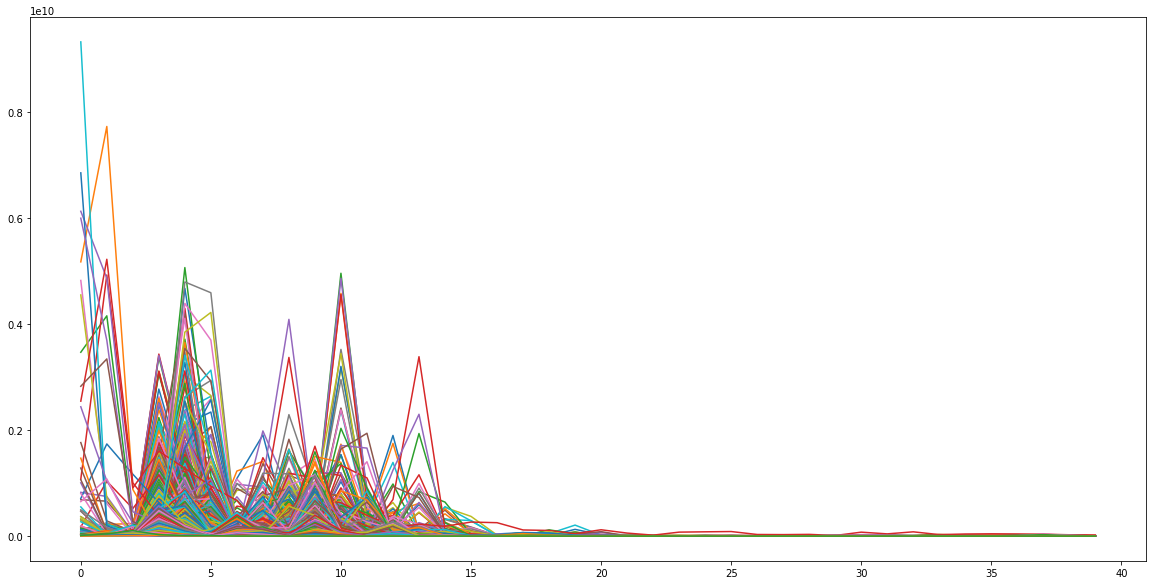

In [29]:
plt.figure(figsize = (20, 10))
for i in range(2723):
    plt.plot(filter_banks[i, :])

In [51]:
filter_banks = 20*np.log10(filter_banks)

In [56]:
#MFCC to remove correlation
#typically for ASR cepstral coeffs from 2-13 contribute. rest don't
n_cep_coeff = 12
mfcccoeff = dct(filter_banks, type = 2, axis = 1, norm = 'ortho')[:, 0:(n_cep_coeff)]
mfcccoeff

array([[ 5.72558811e+02,  1.25618183e+02,  4.05348358e+01, ...,
         8.07768369e+00,  3.03953968e+00,  5.76095229e-01],
       [ 5.76105333e+02,  1.24744462e+02,  3.31762233e+01, ...,
         1.12726288e+01,  7.73461144e+00,  5.73269523e+00],
       [ 6.08469718e+02,  1.01746107e+02,  3.02193219e+01, ...,
         1.33448402e+01,  1.11256465e+01,  8.80154731e+00],
       ...,
       [ 6.24342585e+02,  1.25469720e+02,  5.41209893e+01, ...,
        -1.22640248e+01, -1.14850455e+01, -1.18303623e+01],
       [ 6.26582529e+02,  1.36760991e+02,  6.59263155e+01, ...,
        -5.14716630e+00, -1.02112321e+01, -1.12054850e+01],
       [ 6.32058233e+02,  1.04578820e+02,  4.62081746e+01, ...,
         4.54920414e+00, -7.14808907e+00, -1.26784699e+01]])

In [68]:
mfcc_feat = mfcc(
    data,
    rate,
    winlen = 0.025,
    winstep = 0.015,
    nfilt = 40,
    nfft = 512,
    numcep = 12,
    preemph = 0
)
# np.mean(mfcc_feat, axis = 0)
mfcc_feat[:, 11]

array([  0.79590497,   7.92001115,  12.15978697, ..., -16.3442495 ,
       -15.48094963, -17.51595352])

In [39]:
N = 2
def ctpn(n_cep_coeff, mfcc, t, n):
    if((t+n) > n_cep_coeff-1):
        return mfcc[:,n_cep_coeff-1]
    elif(0 <= (t+n) <= n_cep_coeff-1):
        return mfcc[:, t+n]

def ctmn(n_cep_coeff, mfcc, t, n):
    if((t-n) < 0):
        return mfcc[:,0]
    elif(0 <= (t-n) <= n_cep_coeff-1):
        return mfcc[:, t-n]  
    
def deltacoeff(t):
    dt = 0
    for n in range(1,N):
        dt+= n*(ctpn(n_cep_coeff, mfcc, t, n) - ctmn(n_cep_coeff, mfcc, t, n))/2*np.square(n)
    return dt

def deltacoeff_gen(mfcc, n_cep_coeff):
    deltacoef = np.zeros(mfcc.shape)
    for t in range(0, n_cep_coeff):
        dt = deltacoeff(t)
        deltacoef[:, t] = dt
    return deltacoef

def deltadeltacoeff_gen(deltacoef, n_cep_coeff):
    deltadeltacoef = np.zeros(deltacoef.shape)
    for t in range(0, n_cep_coeff):
        ddt = deltacoeff(t)
        deltadeltacoef[:, t] = ddt
    return deltacoef
    

In [67]:
x = deltacoeff_gen(mfcc, n_cep_coeff)
range(0, int(x[:,0].shape))

TypeError: int() argument must be a string, a bytes-like object or a number, not 'tuple'

Text(0.5,1,'Hamming Window')

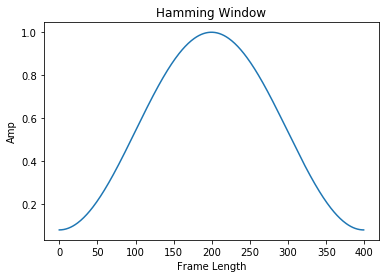

In [40]:
plt.plot(np.hamming(400))
plt.xlabel('Frame Length')
plt.ylabel('Amp')
plt.title('Hamming Window')